This notebook is part of the $\omega radlib$  documentation: http://wradlib.org/wradlib-docs.

Copyright (c) 2016, $\omega radlib$  developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Match spaceborn PR (GPM/TRMM) with ground radars

The main objective is to compute the average reflectivity of high-resolution ground radar sweeps over TRMM/GPM PR bins. IDL code had been provided by Rob Warren based on Schwaller and Morris (2011). This notebook will provide a playground to port this to wradlib.

In [1]:
import wradlib as wradlib
import matplotlib.pyplot as pl
import matplotlib as mpl
from matplotlib.collections import PatchCollection
from matplotlib.colors import from_levels_and_colors
from matplotlib.path import Path
import matplotlib.patches as patches
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
import numpy as np
import datetime as dt
from osgeo import osr

In [2]:
from external import *
from io_func import *

In [3]:
# Orbit parameters
pr_pars = {"trmm": {
   "zt": 402500., # orbital height of TRMM (post boost)   APPROXIMATION!
   "drt": 250. , # gate spacing of TRMM
    }, "gpm": {
   "zt": 407000.,  # orbital height of GPM                 APPROXIMATION!
   "drt": 125.    # gate spacing of GPM
}}
bwt=0.71

In [4]:
# define GPM data set
gpm_file = wradlib.util.get_wradlib_data_file('gpm/2A-RW-BRS.GPM.Ku.V6-20160118.20141206-S095002-E095137.004383.V04A.HDF5')

# define matching ground radar file
gr2gpm_file = wradlib.util.get_wradlib_data_file('hdf5/IDR66_20141206_094829.vol.h5')

# define TRMM data sets
trmm_2A23_file = wradlib.util.get_wradlib_data_file('trmm/2A-RW-BRS.TRMM.PR.2A23.20100206-S111422-E111519.069662.7.HDF')
trmm_2A25_file = wradlib.util.get_wradlib_data_file('trmm/2A-RW-BRS.TRMM.PR.2A25.20100206-S111422-E111519.069662.7.HDF')

# define matching ground radar file
gr2trmm_file = wradlib.util.get_wradlib_data_file('hdf5/IDR66_20100206_111233.vol.h5')

#### Read and organize the data

In [5]:
# read spaceborn PR data
pr_data = read_gpm(gpm_file)
#pr_data = io_func.read_trmm(trmm_2A23_file, trmm_2A25_file)
# read matching GR data
gr_data = read_gr(gr2gpm_file)
#gr_data = wradlib.io.read_generic_hdf5(gr2trmm_file)

#### Creation of GR-Grids

In [38]:
print(gr_data.keys())
ngate = gr_data['ngate']
nbeam = gr_data['nbeam']
ntilt = gr_data['ntilt']
elev = gr_data['elang']
dr = gr_data['dr']
refg = gr_data['refl']
sdate = gr_data['sdate']
r0 = gr_data['r0']
a0 = gr_data['a0']
lon0 = gr_data['lon']
lat0 = gr_data['lat']
alt0 = gr_data['alt']
bwr = 1.

['elang', 'sdate', 'r0', 'source', 'nbeam', 'lon', 'ntilt', 'a0', 'ngate', 'refl', 'date', 'lat', 'alt', 'dr']


In [7]:
# calculate equivalent earth radius
wgs84 = wradlib.georef.get_default_projection()
re1 = wradlib.georef.get_earth_radius(lat0, wgs84) * 4./3.
print("eff. Earth radius 1:", re1)
a = wgs84.GetSemiMajor()
b = wgs84.GetSemiMinor()
print("SemiMajor, SemiMinor:", a, b)


# setup aeqd-projection gr-centered
rad = wradlib.georef.proj4_to_osr(('+proj=aeqd +lon_0={lon:f} ' + 
                                   '+lat_0={lat:f} +a={a:f} ' +
                                   '+b={b:f}').format(lon=lon0,
                                                      lat=lat0,
                                                      a=a, b=b))
re2 = wradlib.georef.get_earth_radius(lat0, rad) * 4./3.
print("eff. Earth radius 2:", re2)

('eff. Earth radius 1:', 8498054.7197525594)
('SemiMajor, SemiMinor:', 6378137.0, 6356752.314245179)
('eff. Earth radius 2:', 8498054.7197525073)


In [8]:
# EXEMPLARY PROCEDURE FOR LOWEST SWEEP

# create gr range and azimuth arrays
rmax = r0[0] + ngate[0] * dr[0]
r = np.arange(0, ngate[0]) * dr[0] + dr[0]/2.
az = np.arange(0, nbeam[0]) - a0[0]
print("Range/Azi-Shape:", r.shape, az.shape)

# create gr lonlat grid
gr_polargrid = np.meshgrid(r, az)
gr_lon, gr_lat, gr_alt = wradlib.georef.polar2lonlatalt_n(gr_polargrid[0], gr_polargrid[1], elev[0], (lon0, lat0, alt0 ))
gr_ll = np.dstack((gr_lon, gr_lat, gr_alt))
print("LonLatAlt-Grid-Shape", gr_ll.shape)

# reproject to xyz
gr_xyz = wradlib.georef.reproject(gr_ll, projection_source=wgs84, projection_target=rad)
print("XYZ-Grid-Shape:", gr_xyz.shape)

# get radar domain (outer ring)
gr_domain = gr_xyz[:,-1,0:2]
gr_domain = np.vstack((gr_domain, gr_domain[0]))
print("Domain-Shape:", gr_domain.shape)

('Range/Azi-Shape:', (600L,), (360L,))
('LonLatAlt-Grid-Shape', (360L, 600L, 3L))
('XYZ-Grid-Shape:', (360L, 600L, 3L))
('Domain-Shape:', (361L, 2L))


#### Creation of PR-Grids

('PR-GRID-Shapes:', (137L, 49L), (137L, 49L), (137L, 49L, 2L))


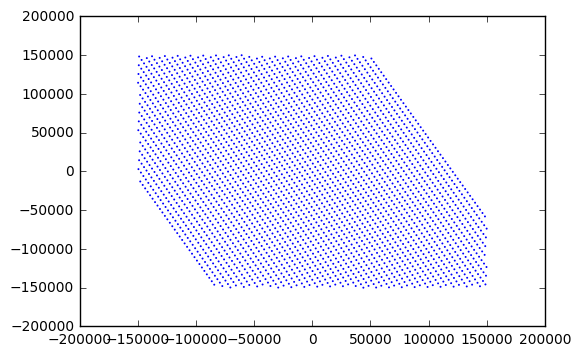

In [11]:
pr_lon = pr_data['lon']
pr_lat = pr_data['lat']
pr_x, pr_y = wradlib.georef.reproject(pr_lon, pr_lat, 
                                      projection_source=wgs84, 
                                      projection_target=rad)
pr_xy = np.dstack((pr_x, pr_y))
print("PR-GRID-Shapes:", pr_x.shape, pr_y.shape, pr_xy.shape)

# get boolean array of pr-bins within gr-array
# crude method box-based
iover = ((pr_x >= -rmax) & (pr_x <= rmax) & 
         (pr_y >= -rmax) & (pr_y <= rmax))

pl.scatter(pr_x[iover], pr_y[iover], s=2, edgecolor="None")

#### Creating ZonalDataPoint

In [12]:
l_gr = []
l_gr.append(gr_domain)
zd = wradlib.zonalstats.ZonalDataPoint(pr_xy.reshape(-1, pr_xy.shape[-1]), l_gr, srs=rad, buf=500.)
obj1 = wradlib.zonalstats.GridPointsToPoly(zd)

Calculate Intersection source/target-layers


#### Get precipitating PR-Bins

In [13]:
# get source indices within GR-Domain from zonal object
# 0 because we have only one zone
pr_idx = obj1.zdata.get_source_index(0) 

# get precip flag from pr_data
pflag = pr_data['pflag']

# create src_idx
src_idx = np.zeros_like(pflag, dtype=np.bool)
mask = np.unravel_index(pr_idx, pflag.shape)
src_idx[mask] = True

# get precip indexes
precip_mask = (pflag == 2)
precip_idx = src_idx & precip_mask

# get iscan/iray boolean arrays
iscan = precip_idx.nonzero()[0]
iray = precip_idx.nonzero()[1]

#### PR Parallax Correction

In [21]:
pr_dr = 125.
pr_nray = pr_data['nray']
pr_nbin = pr_data['nbin']
pr_nscan= pr_data['nscan']
print("NRAY", pr_nray)
print("NBIN", pr_nbin)

# approximation
alpha = abs(-17.04 + np.arange(pr_nray) * 0.71)

# correct parallax, get 3D-XYZ-Array
pr_xyzp, prng, zp = correct_parallax(pr_xy, pr_nray, pr_nbin, pr_dr, alpha)

print("PR_XYP:", pr_xyzp.shape, zp.shape)

('NRAY', 49L)
('NBIN', 176L)
('PRANGE:', (176L,), 21875.0)
('HEIGHT:', (49L, 176L), 21875.0)
('XDIFF:', (137L, 49L))
('Ang:', (137L, 49L))
('DX:', (137L, 49L, 176L))
('XP:', (137L, 49L, 176L))
('PR_XYP:', (137L, 49L, 176L, 3L), (49L, 176L))


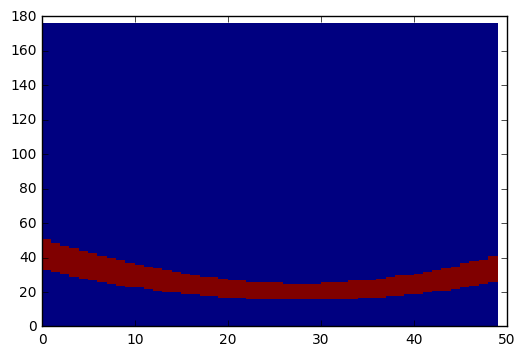

In [15]:
# Calculate spherical coordinates with regard to radar
# TODO: Do we have to consider refraction in sat2pol?
pr_r, pr_elev, pr_az = sat2pol(pr_xyzp, (lon0, lat0, alt0), re1)    
mask = (pr_elev > (1.0 - bwt/2)) & (pr_elev < (1.0 + bwt/2))
pl.figure()
pl.pcolormesh(mask[90,:,:].T)

(3.5698741982061719, 3.6855495697272649)
(2.3490809328054039, 2.59649310524643)


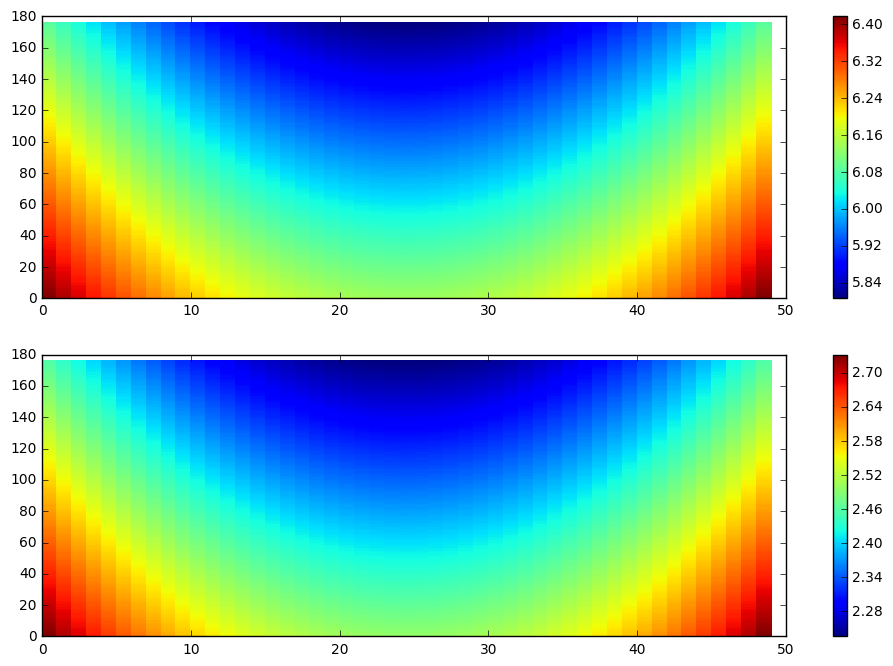

In [95]:
# Compute pulse volumes of PR bins
zt = pr_pars["gpm"]["zt"]

# PV according IDL-Code
pr_volp = pulse_volume(zt, prng, alpha, bwt)
rt = zt/np.cos(np.deg2rad(alpha))[:, np.newaxis] - prng
pr_volp=pr_volp*1e6

# PV according wradlib function
pr_volp2 = 1e-9*np.pi * prng[1] * (rt ** 2) * (np.tan(np.radians(bwt/2.))) ** 2

fig = pl.figure(figsize=(12,8))
ax = fig.add_subplot(211)
pm = pl.pcolor(pr_volp.T)#, vmin=np.stack((pv1,pv2)).min(), vmax=np.stack((pv1,pv2)).max() )
pl.colorbar(pm)
ax = fig.add_subplot(212)
pm = pl.pcolor(pr_volp2.T)#, vmin=np.stack((pv1,pv2)).min(), vmax=np.stack((pv1,pv2)).max() )
pl.colorbar(pm)

# print min/max difference
print((pr_volp-pr_volp2).min(), (pr_volp-pr_volp2).max())
print((pr_volp/pr_volp2).min(), (pr_volp/pr_volp2).max())


#### Median Brightband Width/Height

('ZBB', (137L, 49L), -1111.1, 4814.7271)
('BBWidth', (137L, 49L), -1111.1, 1340.8645)
('MEDIAN:', 3855.8948, 747.69403)
('ZMLT:', (137L, 49L))
('RATIO:', (137L, 49L, 176L))


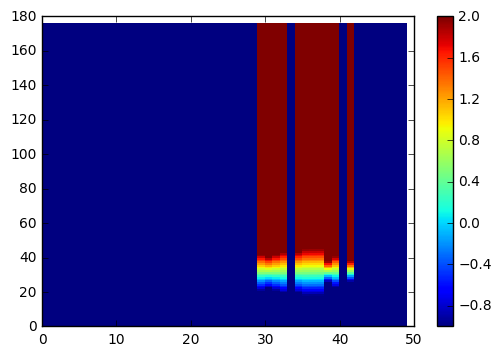

In [17]:
ratio = get_bb_ratio(pr_data, zp)
pl.figure()
pl.pcolormesh(ratio[60,:,:].T, vmin=-1, vmax=2)
pl.colorbar()

#### Convert Ku to S-band using Cao et.al. and S to Ku using Liao and Meneghini

('REFP:', (137L, 49L, 176L))


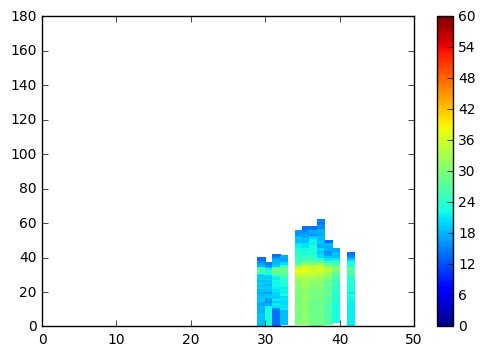

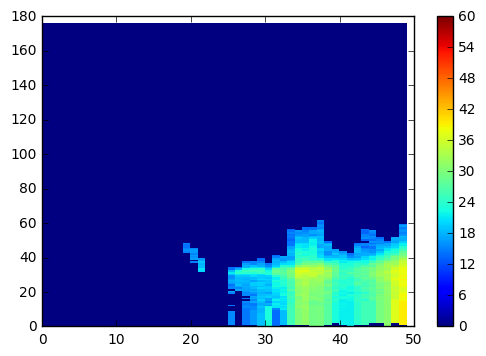

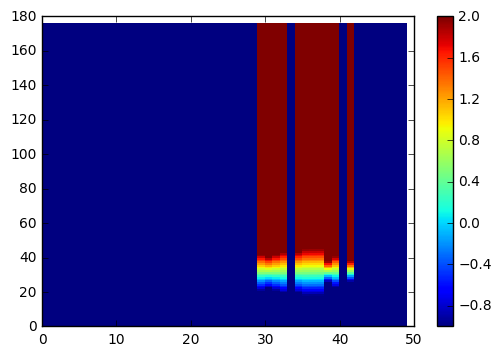

In [18]:
# REVERSE!!!
refp = pr_data['refl'][:,:,::-1]
print("REFP:", refp.shape)

refp_ss = np.zeros_like(refp) * np.nan
refp_sh = np.zeros_like(refp) * np.nan

a_s, a_h = s_ku_coefficients()

ia = (ratio >= 1)
refp_ss[ia] = refp[ia] + calculate_polynomial(refp[ia], a_s[:,10])
refp_sh[ia] = refp[ia] + calculate_polynomial(refp[ia], a_h[:,10])
ib = (ratio <= 0)
refp_ss[ib] = refp[ib] + calculate_polynomial(refp[ib], a_s[:,0])
refp_sh[ib] = refp[ib] + calculate_polynomial(refp[ib], a_h[:,0])
im = (ratio > 0) & (ratio < 1)
ind = np.round(ratio[im] * 10).astype(np.int)
#print("W:", a_s[:,ind].shape)
refp_ss[im] = refp[im] + calculate_polynomial(refp[im], a_s[:,ind])
refp_sh[im] = refp[im] + calculate_polynomial(refp[im], a_h[:,ind])

refp_ss[refp < 0] = np.nan
out = np.ma.masked_invalid(refp_ss)
pl.figure()
pl.pcolormesh(out[60,:,:].T, vmin=0, vmax=60)
pl.colorbar()
pl.figure()
pl.pcolormesh(refp[60,:,:].T, vmin=0, vmax=60)
pl.colorbar()
pl.figure()
pl.pcolormesh(ratio[60,:,:].T, vmin=-1, vmax=2)
pl.colorbar()

#### Beginning with actual matching

In [23]:
# Compute path-integrated reflectivities at every point
irefp=REVERSE(TOTAL(REVERSE(10^(refp/10),2),2,/cumulative,/nan),2)
irefg=TOTAL(10^(refg/10),1,/cumulative,/nan)
irefp=(irefp-(10^(refp/10))/2.)*drt
irefg=(irefg-(10^(refg/10))/2.)*dr
irefp=10*ALOG10(irefp)
irefg=10*ALOG10(irefg)

; Convert to linear units
if l_dbz eq 0 then begin
 refp=10^(refp/10)
 refg=10^(refg/10)
 refp_ss=10^(refp_ss/10)
 refp_sh=10^(refp_sh/10)
 refg_ku=10^(refg_ku/10)
endif
irefp=10^(irefp/10)
irefg=10^(irefg/10)
if l_dp eq 1 then begin
 refu=10^(refu/10)
 zdr=10^(zdr/10)
endif

;rad2=rad
;rad2.refl=10*ALOG10(irefg)

In [99]:
# Option no 1: Loop over PR profiles (as in Rob's code)
ee = 0
# indicates which bins should be in sample
valid = np.asarray(pr_elev, dtype=np.bool)==False
# inside range and precipitating
valid[iscan,iray] = True
# inside GR tilt
valid = valid & (pr_elev >= elev[ee]-bwr/2.) & (pr_elev <= elev[ee]+bwr/2.)
# number of matching bins per profile
nvalids = np.sum(valid, axis=2)
vscan, vray = np.where(nvalids>10)
nprof = len(vscan)

In [120]:
# Lots of containers to store samples
x=np.zeros(nprof)*np.nan       # x coordinate of sample
y=np.zeros(nprof)*np.nan       # y coordinate of sample
z=np.zeros(nprof)*np.nan       # z coordinate of sample
dz=np.zeros(nprof)*np.nan      # depth of sample
ds=np.zeros(nprof)*np.nan      # width of sample
r=np.zeros(nprof)*np.nan       # range of sample from GR
ref1=np.zeros(nprof)*np.nan    # PR reflectivity
ref2=np.zeros(nprof)*np.nan    # PR reflectivity (S-band, snow)
ref3=np.zeros(nprof)*np.nan    # PR reflectivity (S-band, hail)  
ref4=np.zeros(nprof)*np.nan    # GR reflectivity
ref5=np.zeros(nprof)*np.nan    # GR reflectivity (Ku-band)
ntot1=np.zeros(nprof,dtype="i4")# total number of PR bins in sample
nrej1=np.zeros(nprof,dtype="i4")# number of rejected PR bins in sample
ntot2=np.zeros(nprof,dtype="i4")# total number of GR bins in sample
nrej2=np.zeros(nprof,dtype="i4")# number of rejected GR bins in sample
iref1=np.zeros(nprof)*np.nan    # path-integrated PR reflectivity
iref2=np.zeros(nprof)*np.nan    # path-integrated GR reflectivity
stdv1=np.zeros(nprof)*np.nan    # std. dev. of PR reflectivity in sample
stdv2=np.zeros(nprof)*np.nan    # std. dev. of GR reflectivity in sample
vol1=np.zeros(nprof)*np.nan     # total volume of PR bins in sample
vol2=np.zeros(nprof)*np.nan     # total volume of GR bins in sample

In [126]:
drt = pr_pars["gpm"]["drt"]
for ii, (ss, rr)  in enumerate(zip(vscan,vray)):
    # Index and count valid bins in each profile
    ip = np.where(valid[ss,rr])[0]
    numbins = len(ip)
    ntot1[ii]=numbins
    if numbins == 0:
        continue
    # Compute the mean position of these bins
    x[ii]=np.mean(pr_xyzp[ss,rr,0])
    y[ii]=np.mean(pr_xyzp[ss,rr,1])
    z[ii]=np.mean(pr_xyzp[ss,rr,2])

    # Thickness of the layer
    dz[ii]=(numbins * drt) * np.cos( np.radians(alpha[rr]) )

    # PR averaging volume
    vol1[ii]=np.sum(pr_volp[rr,ip])

    # Note mean TRMM beam diameter
    ds[ii]=np.radians(bwt) * np.mean( ( (zt-z[ii]) / np.cos( np.radians(alpha[rr]) ) ) )

    # Note distance from radar
    s=np.sqrt(x[ii]**2+y[ii]**2)
    r[ii]=(re2+z[ii]) * np.sin(s/re2) / np.cos(np.radians(elev[ee]))
    
    # This should not be required after we applied ZonalData
    ### Check that sample is within radar range
    ##if r[ii,jj]+ds[ii,jj]/2. gt rmax then continue

    # Extract the relevant PR data
    refp1=refp[ss,rr,ip]
    refp2=refp_ss[ss,rr,ip]
    refp3=refp_sh[ss,rr,ip]
    ##irefp1=irefp[ss,rr,ip]
    
    # Average over those bins that exceed the reflectivity
    # threshold (linear average)
    ref1[ii]=np.nanmean(refp1)
    ref3[ii]=np.nanmean(refp2)
    ref4[ii]=np.nanmean(refp3)
    
    ## Not sure why we need this...
    ### Note the number of rejected bins
    ##nrej1[ii,jj]=ROUND(TOTAL(FINITE(refp1,/nan)))
    ##if FINITE(stdv1[ii,jj]) eq 0 and np-nrej1[ii,jj] gt 1 then STOP

    # SHOULD WE BRING IN ZONALDATA HERE?
    # Compute the horizontal distance to all the GR bins
    d=SQRT((xg[*,*,jj]-x[ii,jj])^2+(yg[*,*,jj]-y[ii,jj])^2)

    ; Find all GR bins within the SR beam
    ig=WHERE(d le ds[ii,jj]/2.,ng)

    ; Store the number of bins
    ntot2[ii,jj]=ng

    if ng eq 0 then continue

    ; Extract the relevant GR data
    refg1=(refg[*,*,jj])[ig]
    refg2=(refg_ku[*,*,jj])[ig]
    volg1=(volg[*,*,jj])[ig]
    irefg1=(irefg[*,*,jj])[ig]
    if l_dp eq 1 then begin
       refu1=(refu[*,*,jj])[ig]
       zdr1=(zdr[*,*,jj])[ig]
    endif

    ; Compute the GR averaging volume
    vol2[ii,jj]=TOTAL(volg1)


array([ 16.69000053,  17.5       ,  17.48999977,  14.65999985,
        15.69999981,  17.45000076,  16.59000015,  16.61000061,
        18.17000008,  16.59000015,  20.04999924,  18.12999916,
        19.40999985,  17.35000038,  18.07999992,  19.97999954,
        18.71999931,  17.30999947,  17.31999969,  19.37000084,  23.01000023], dtype=float32)

In [112]:
pr_volp.shape

(49L, 176L)

In [113]:
rr

27

In [114]:
ip

array([   0,    0,    0, ..., 1191, 1191, 1191], dtype=int64)